In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import kurtosis

import datetime as dt

from IPython.display import clear_output

import gc
import sys
sys.path.append( 'info_metrics/')

from entropy_metrics import *

In [2]:
def column_merger(columns):
    columns = ['%s%s' % (a, '_%s' % b if b else '') for a, b in columns]
    return columns

def count_unique(series):
    return len(np.unique(series))

def mean_absolute_deviation(x):
    return np.mean(np.abs(x - np.mean(x)))

def mask_df(df, year, domain, traffic, day=None, month=None):
    if day != None:
        return ((df["year"] == year) & (df["day"] == day) & (df["domain"] == domain) & (df["trafficType"] == traffic))
    if month != None:
        return ((df["year"] == year) & (df["month"] == month) & (df["domain"] == domain) & (df["trafficType"] == traffic))
    if domain == None and traffic == None and day != None:
        return ((df["year"] == year) & (df["day"] == day))
    else:
        return ((df["year"] == year) & (df["domain"] == domain) & (df["trafficType"] == traffic))


def m1(df, year, month=None, day=None, hour=None, domain=None, traffic=None):
    
    if year != None and month != None and day != None and domain != None and traffic != None :
        return ((df["year"] == year) & (df["month"] == month) & (df["day"] == day) & (df["domain"] == domain) & (df["trafficType"] == traffic))
    
    elif year != None and month != None and day != None and traffic != None :
        return ((df["year"] == year) & (df["month"] == month) & (df["day"] == day) & (df["trafficType"] == traffic))
    
    elif year != None and month != None and day != None and domain != None :
        return ((df["year"] == year) & (df["month"] == month) & (df["day"] == day) & (df["domain"] == domain))
    
    elif year != None and month != None and day != None:
        return ((df["year"] == year) & (df["month"] == month) & (df["day"] == day))
    
    elif year != None and month != None:
        return (df["year"] == year) & (df["month"] == month)

    elif year != None:
        return (df["year"] == year)

    else:
        raise ValueError


def extract_top_domain(df, num_top_domains_per_year):
    """ TEMPORARY """
    num_top_domains = num_top_domains_per_year
    df_sort_2019 = df.mask(df1["year"]==2019).sort_values("CumCount", ascending=False).reset_index(drop=True)
    df_sort_2018 = df.mask(df1["year"]==2018).sort_values("CumCount", ascending=False).reset_index(drop=True)
    top_10_domains_2019 = df_sort_2019["domain"].unique()[0:num_top_domains]
    top_10_domains_2018 = df_sort_2018["domain"].unique()[0:num_top_domains]
    top_domains = np.unique(np.concatenate([top_10_domains_2019, top_10_domains_2018])).flatten()
    return top_domains


In [3]:
df = pd.read_parquet("../../data/small/A2.parquet")

unique_domains = df["domain"].unique()
unique_traffictype = df["trafficType"].unique()

df["Date"] = pd.to_datetime(df["timestamp"], unit="s")

df1 = df.groupby(by=["domain", "Date","trafficType"]).agg("sum").reset_index()

df1 = df1.sort_values(by=["Date", "domain"], ascending=True)

df1["year"] = df1["Date"].dt.year
df1["month"] = df1["Date"].dt.month
df1["day"] = df1["Date"].dt.day
df1["hour"] = df1["Date"].dt.hour
df1.drop("timestamp", inplace=True, axis=1)
df1 = df1.reset_index(drop=True)
df1

,domain,Date,trafficType,CumCount,year,month,day,hour
0,(�,2018-09-01 00:00:00,spider,1,2018,9,1,0
1,aa.wikibooks,2018-09-01 00:00:00,spider,66,2018,9,1,0
2,aa.wikibooks,2018-09-01 00:00:00,user,2,2018,9,1,0
3,aa.wikipedia,2018-09-01 00:00:00,spider,18,2018,9,1,0
4,aa.wikipedia,2018-09-01 00:00:00,user,16,2018,9,1,0
...,...,...,...,...,...,...,...,...
7240497,zu.wikibooks,2020-01-21 23:00:00,spider,4,2020,1,21,23
7240498,zu.wikibooks,2020-01-21 23:00:00,user,2,2020,1,21,23
7240499,zu.wikipedia,2020-01-21 23:00:00,spider,32,2020,1,21,23
7240500,zu.wikipedia,2020-01-21 23:00:00,user,33,2020,1,21,23


In [18]:
top_domains = extract_top_domain(df1, 5)
df1 = df1[df1["domain"].isin(top_domains)]
assert(df1[m1(df1, 2018, 9, 1)].shape == df1[m1(df1, 2018, 10, 1)].shape)
top_domains

array(['commons.wikimedia', 'de.wikipedia', 'en.wikipedia',
       'en.wikisource', 'es.wikipedia', 'fr.wikipedia', 'zh.wikipedia'],
      dtype=object)

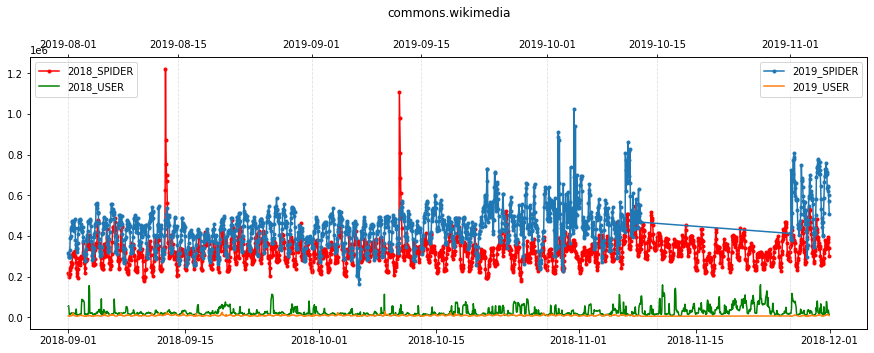

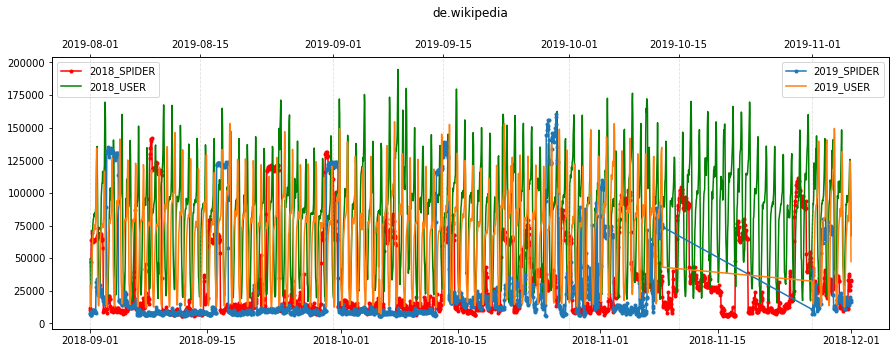

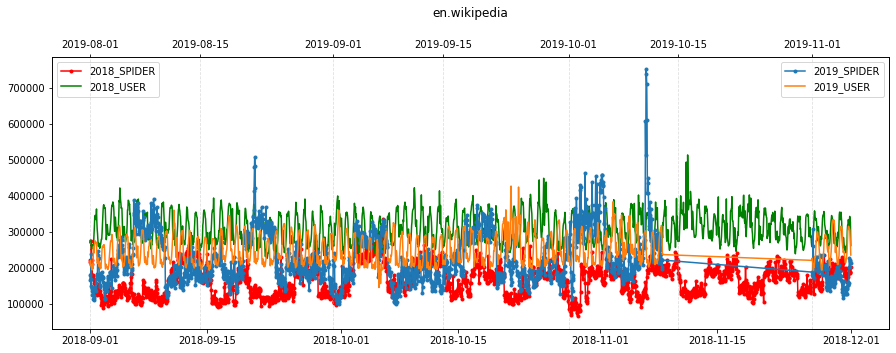

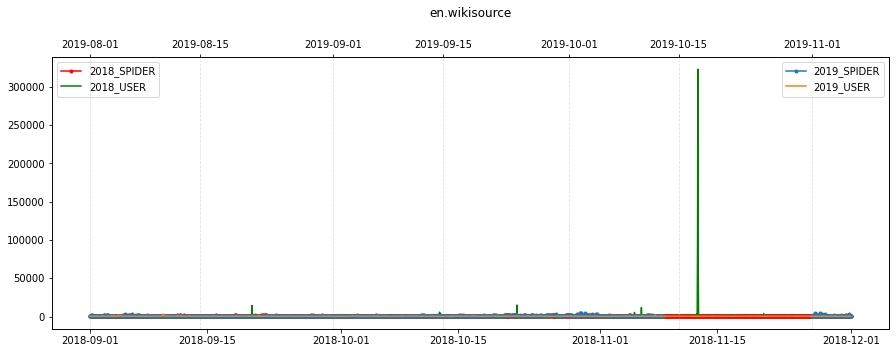

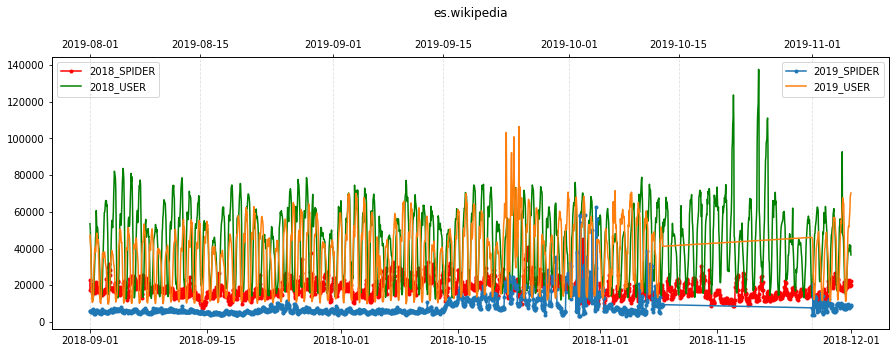

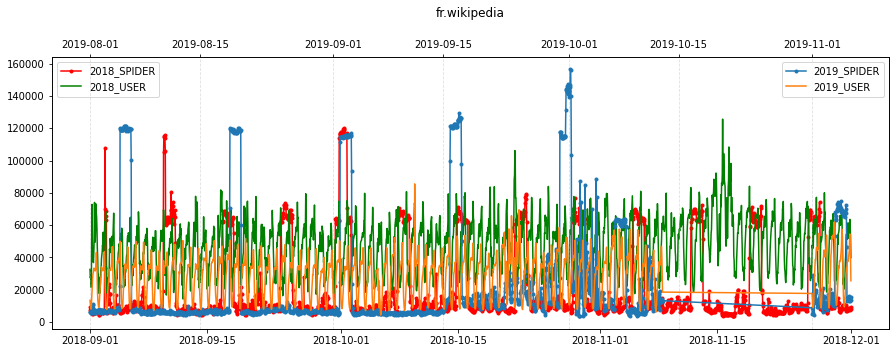

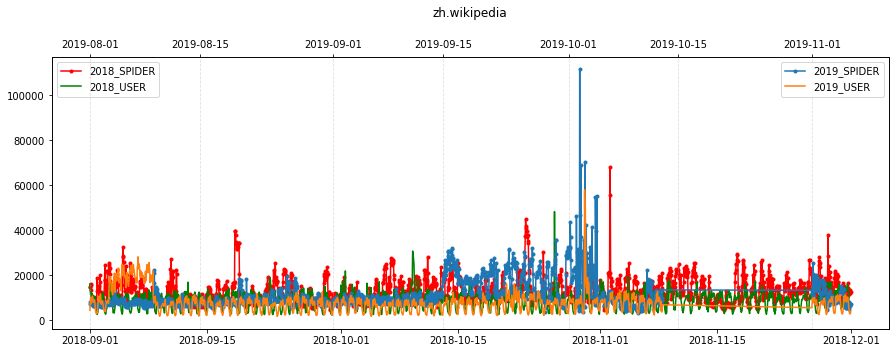

In [19]:
for domain in top_domains:

    fig, ax1 = plt.subplots(figsize=(15,5))

    ax1.set_title(domain, pad=40)
    ax1.plot(df1.Date[mask_df(df1, 2018, domain, "spider")], df1.CumCount[mask_df(df1, 2018, domain,  "spider")], color="r", marker=".", label="2018_SPIDER")
    ax1.plot(df1.Date[mask_df(df1, 2018, domain, "user")], df1.CumCount[mask_df(df1, 2018, domain, "user")], color="g", label="2018_USER")
    ax1.legend(loc=2)

    ax2 = ax1.twiny()

    ax2.plot(df1.Date[mask_df(df1, 2019, domain, "spider")], df1.CumCount[mask_df(df1, 2019, domain,  "spider")], marker=".", label="2019_SPIDER")
    ax2.plot(df1.Date[mask_df(df1, 2019, domain, "user")], df1.CumCount[mask_df(df1, 2019, domain, "user")],  label="2019_USER")
    ax2.legend(loc=1)

    plt.grid(linestyle="--", alpha=0.4)
    plt.show()


# Information Metrics



In [20]:
df1 = df1.sort_values(by=["year", "month", "day", "hour", "trafficType", "domain"], ascending=True).reset_index(drop=True)
df1["access_frequency"] = 1/df1["CumCount"]
df1

,domain,Date,trafficType,CumCount,year,month,day,hour,access_frequency
0,commons.wikimedia,2018-09-01 00:00:00,spider,219606,2018,9,1,0,0.000005
1,de.wikipedia,2018-09-01 00:00:00,spider,11977,2018,9,1,0,0.000083
2,en.wikipedia,2018-09-01 00:00:00,spider,222363,2018,9,1,0,0.000004
3,en.wikisource,2018-09-01 00:00:00,spider,758,2018,9,1,0,0.001319
4,es.wikipedia,2018-09-01 00:00:00,spider,22600,2018,9,1,0,0.000044
...,...,...,...,...,...,...,...,...,...
63835,en.wikipedia,2020-01-21 23:00:00,user,243932,2020,1,21,23,0.000004
63836,en.wikisource,2020-01-21 23:00:00,user,296,2020,1,21,23,0.003378
63837,es.wikipedia,2020-01-21 23:00:00,user,50676,2020,1,21,23,0.000020
63838,fr.wikipedia,2020-01-21 23:00:00,user,25837,2020,1,21,23,0.000039


In [21]:
date_combinations = df1.groupby(by= ["year", "month"]).groups.keys()
date_combinations

dict_keys([(2018, 9), (2018, 10), (2018, 11), (2019, 8), (2019, 9), (2019, 10), (2019, 11), (2020, 1)])

In [22]:
daysinmonths ={
    "1":"31",
    "2":"28",
    "3":"31",
    "4":"30",
    "5":"31",
    "6":"30",
    "7":"30",
    "8":"31",
    "9":"30",
    "10":"31",
    "11":"30",
    "12":"31"
}

In [23]:
days = np.array(range(1,31))
months = np.array(df1.month.unique())
years = np.array(df1.year.unique())

months_2018 = np.array([9,10,11])

KLV_DIV = np.zeros((len(months_2018), len(days)))

for i, month in enumerate(months_2018):
    for j, day in enumerate(days):
        
        clear_output(wait=True)
        print("MONTH/DAY: ", month ,"/", day)

        x = df1.access_frequency[m1(df1, year=years[1], month=9, day=day)].to_numpy()
        y = df1.access_frequency[m1(df1, year=years[0], month=month, day=day)].to_numpy()
        x = x.reshape(-1,1)
        y = y.reshape(-1,1)

        KLV_DIV[i,j] = kldiv(x,y, k=3)


MONTH/DAY:  11 / 30


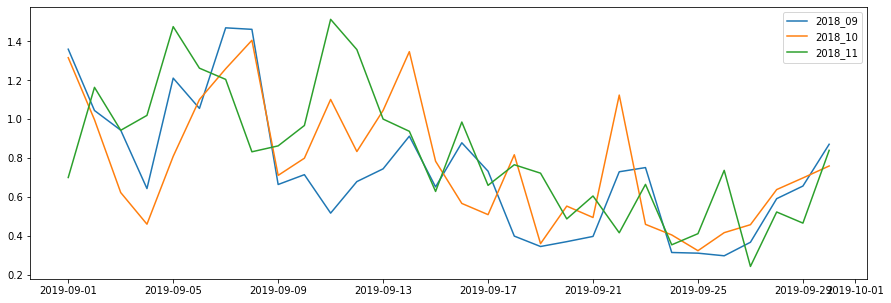

In [24]:
dates = pd.date_range(start=dt.datetime(2019,9,1), end=dt.datetime(2019,9,30), freq="D")

plt.figure(figsize=(15,5))
plt.plot(dates, KLV_DIV[0,::], label="2018_09")
plt.plot(dates, KLV_DIV[1,::], label="2018_10")
plt.plot(dates, KLV_DIV[2,::], label="2018_11")
plt.legend()
plt.show()

In [25]:
# IMPORTANT SORT 
df1 = df1.sort_values(by=["year", "month", "day", "hour", "trafficType", "domain"], ascending=True).reset_index(drop=True)

In [26]:
days = np.array(range(1,31))
months = np.array(df1.month.unique())
years = np.array(df1.year.unique())

months_2018 = np.array([9,10,11])
traffics = np.array([None, "user", "spider"])

KLV_DIV_2019_09 = np.zeros((len(traffics), len(months_2018), len(days)))
MI_2019_09 = np.zeros((len(traffics), len(months_2018), len(days)))
CENTROPY_2019_09 = np.zeros((len(traffics), len(months_2018), len(days)))

for k, traffic in enumerate(traffics):
    for i, month in enumerate(months_2018):
        for j, day in enumerate(days):
            mean_kldiv = np.zeros(len(days))
            mean_mi = np.zeros(len(days))
            mean_ce = np.zeros(len(days))

            for l, day2 in enumerate(days):
                
                clear_output(wait=True)
                print("TRAFFIC: ", traffic)
                print("MONTH/DAY: ", month ,"/", day, "/", day2)

                x = df1.access_frequency[m1(df1, year=years[1], month=9, day=day, domain=None, traffic=traffic)].to_numpy()
                y = df1.access_frequency[m1(df1, year=years[0], month=month, day=day2, domain=None, traffic=traffic)].to_numpy()
                x = x.reshape(-1,1)
                y = y.reshape(-1,1)

                mean_kldiv[l] = kldiv(x,y, k=3)
                mean_mi[l] = mi(x,y, k=3)
                mean_ce[l] = centropy(x,y, k=3)

            KLV_DIV_2019_09[k,i,j] = np.nanmean(mean_kldiv[np.isfinite(mean_kldiv)])
            MI_2019_09[k,i,j] = np.nanmean(mean_mi[np.isfinite(mean_mi)])
            CENTROPY_2019_09[k,i,j] = np.nanmean(mean_ce[np.isfinite(mean_ce)])


TRAFFIC:  spider
MONTH/DAY:  11 / 30 / 30


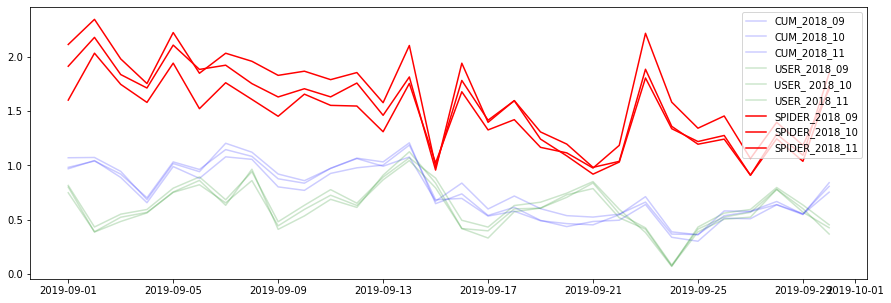

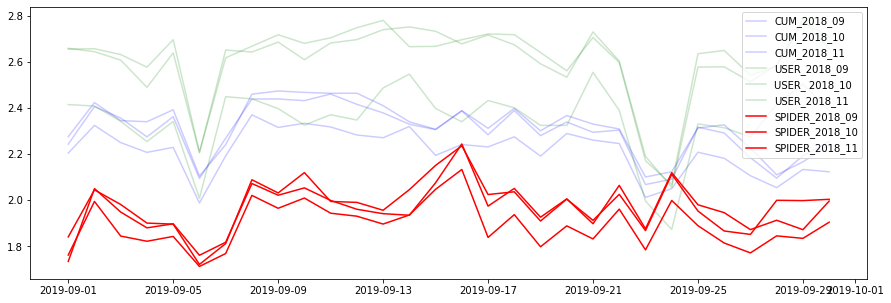

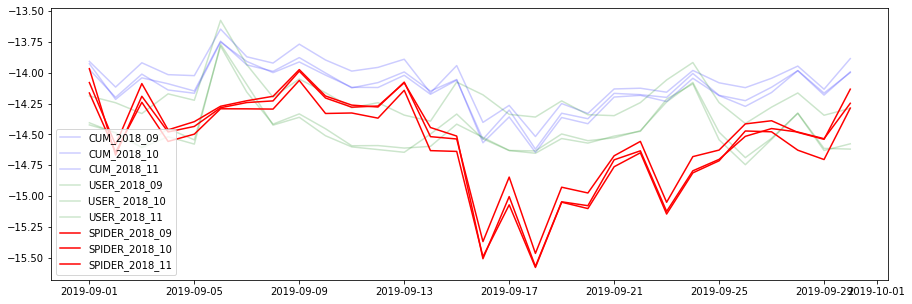

In [ ]:
dates = pd.date_range(start=dt.datetime(2019,9,1), end=dt.datetime(2019,9,30), freq="D")

plt.figure(figsize=(15,5))
plt.plot(dates, KLV_DIV_2019_09[0, 0,::], alpha=0.2, color="b", label="CUM_2018_09")
plt.plot(dates, KLV_DIV_2019_09[0, 1,::], alpha=0.2, color="b", label="CUM_2018_10")
plt.plot(dates, KLV_DIV_2019_09[0, 2,::], alpha=0.2, color="b", label="CUM_2018_11")
plt.plot(dates, KLV_DIV_2019_09[1, 0,::], alpha=0.2, color="g", label="USER_2018_09")
plt.plot(dates, KLV_DIV_2019_09[1, 1,::], alpha=0.2, color="g", label="USER_ 2018_10")
plt.plot(dates, KLV_DIV_2019_09[1, 2,::], alpha=0.2, color="g", label="USER_2018_11")
plt.plot(dates, KLV_DIV_2019_09[2, 0,::], color="r", label="SPIDER_2018_09")
plt.plot(dates, KLV_DIV_2019_09[2, 1,::], color="r", label="SPIDER_2018_10")
plt.plot(dates, KLV_DIV_2019_09[2, 2,::], color="r", label="SPIDER_2018_11")

plt.legend()
plt.show()

plt.figure(figsize=(15,5))
plt.plot(dates, MI_2019_09[0, 0,::], alpha=0.2, color="b", label="CUM_2018_09")
plt.plot(dates, MI_2019_09[0, 1,::], alpha=0.2, color="b", label="CUM_2018_10")
plt.plot(dates, MI_2019_09[0, 2,::], alpha=0.2, color="b", label="CUM_2018_11")
plt.plot(dates, MI_2019_09[1, 0,::], alpha=0.2, color="g", label="USER_2018_09")
plt.plot(dates, MI_2019_09[1, 1,::], alpha=0.2, color="g", label="USER_ 2018_10")
plt.plot(dates, MI_2019_09[1, 2,::], alpha=0.2, color="g", label="USER_2018_11")
plt.plot(dates, MI_2019_09[2, 0,::], color="r", label="SPIDER_2018_09")
plt.plot(dates, MI_2019_09[2, 1,::], color="r", label="SPIDER_2018_10")
plt.plot(dates, MI_2019_09[2, 2,::], color="r", label="SPIDER_2018_11")

plt.legend()
plt.show()


plt.figure(figsize=(15,5))
plt.plot(dates, CENTROPY_2019_09[0, 0,::], alpha=0.2, color="b", label="CUM_2018_09")
plt.plot(dates, CENTROPY_2019_09[0, 1,::], alpha=0.2, color="b", label="CUM_2018_10")
plt.plot(dates, CENTROPY_2019_09[0, 2,::], alpha=0.2, color="b", label="CUM_2018_11")
plt.plot(dates, CENTROPY_2019_09[1, 0,::], alpha=0.2, color="g", label="USER_2018_09")
plt.plot(dates, CENTROPY_2019_09[1, 1,::], alpha=0.2, color="g", label="USER_ 2018_10")
plt.plot(dates, CENTROPY_2019_09[1, 2,::], alpha=0.2, color="g", label="USER_2018_11")
plt.plot(dates, CENTROPY_2019_09[2, 0,::], color="r", label="SPIDER_2018_09")
plt.plot(dates, CENTROPY_2019_09[2, 1,::], color="r", label="SPIDER_2018_10")
plt.plot(dates, CENTROPY_2019_09[2, 2,::], color="r", label="SPIDER_2018_11")

plt.legend()
plt.show()


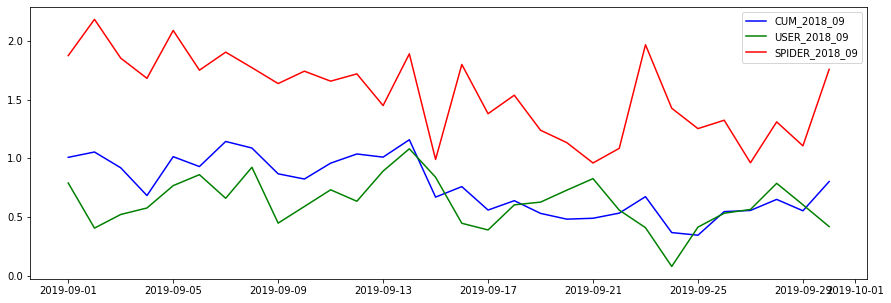

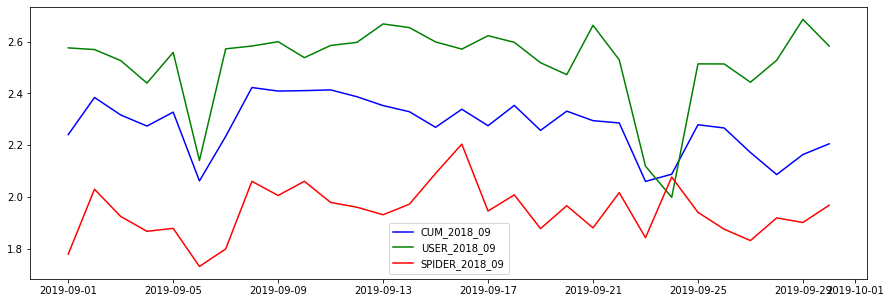

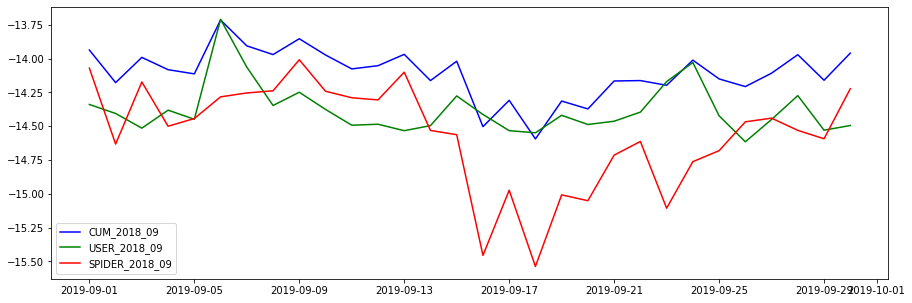

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(dates, np.mean(KLV_DIV_2019_09[0,::,::], axis=0), color="b", label="CUM_2018_09")
plt.plot(dates, np.mean(KLV_DIV_2019_09[1,::,::], axis=0), color="g", label="USER_2018_09")
plt.plot(dates, np.mean(KLV_DIV_2019_09[2,::,::], axis=0), color="r", label="SPIDER_2018_09")

plt.legend()
plt.show()


plt.figure(figsize=(15,5))
plt.plot(dates, np.mean(MI_2019_09[0,::,::], axis=0), color="b", label="CUM_2018_09")
plt.plot(dates, np.mean(MI_2019_09[1,::,::], axis=0), color="g", label="USER_2018_09")
plt.plot(dates, np.mean(MI_2019_09[2,::,::], axis=0), color="r", label="SPIDER_2018_09")

plt.legend()
plt.show()

plt.figure(figsize=(15,5))
plt.plot(dates, np.mean(CENTROPY_2019_09[0,::,::], axis=0), color="b", label="CUM_2018_09")
plt.plot(dates, np.mean(CENTROPY_2019_09[1,::,::], axis=0), color="g", label="USER_2018_09")
plt.plot(dates, np.mean(CENTROPY_2019_09[2,::,::], axis=0), color="r", label="SPIDER_2018_09")

plt.legend()
plt.show()



In [ ]:
days = np.array(range(1,31))
months = np.array(df1.month.unique())
years = np.array(df1.year.unique())

months_2018 = np.array([9,10,11])
traffics = np.array([None, "user", "spider"])

KLV_DIV_2019_08 = np.zeros((len(traffics), len(months_2018), len(days)))
MI_2019_08 = np.zeros((len(traffics), len(months_2018), len(days)))
CENTROPY_2019_08 = np.zeros((len(traffics), len(months_2018), len(days)))

for k, traffic in enumerate(traffics):
    for i, month in enumerate(months_2018):
        for j, day in enumerate(days):
            mean_kldiv = np.zeros(len(days))
            mean_mi = np.zeros(len(days))
            mean_ce = np.zeros(len(days))

            for l, day2 in enumerate(days):
                
                clear_output(wait=True)
                print("TRAFFIC: ", traffic)
                print("MONTH/DAY: ", month ,"/", day, "/", day2)

                x = df1.access_frequency[m1(df1, year=years[1], month=8, day=day, domain=None, traffic=traffic)].to_numpy()
                y = df1.access_frequency[m1(df1, year=years[0], month=month, day=day2, domain=None, traffic=traffic)].to_numpy()
                x = x.reshape(-1,1)
                y = y.reshape(-1,1)

                mean_kldiv[l] = kldiv(x,y, k=3)
                mean_mi[l] = mi(x,y, k=3)
                mean_ce[l] = centropy(x,y, k=3)

            KLV_DIV_2019_08[k,i,j] = np.nanmean(mean_kldiv[np.isfinite(mean_kldiv)])
            MI_2019_08[k,i,j] = np.nanmean(mean_mi[np.isfinite(mean_mi)])
            CENTROPY_2019_08[k,i,j] = np.nanmean(mean_ce[np.isfinite(mean_ce)])


TRAFFIC:  spider
MONTH/DAY:  11 / 30 / 30


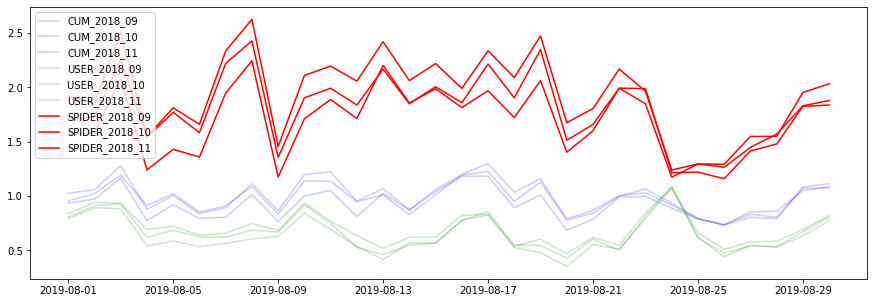

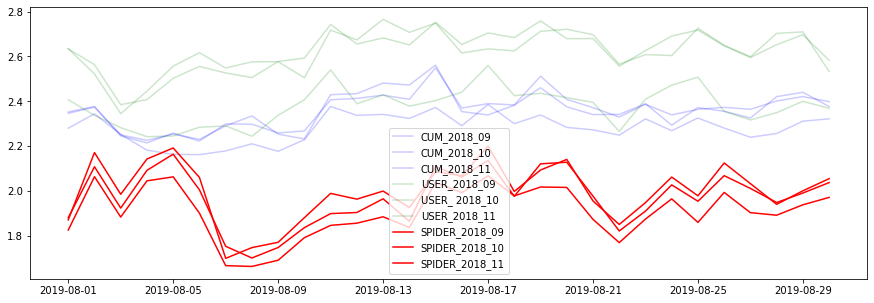

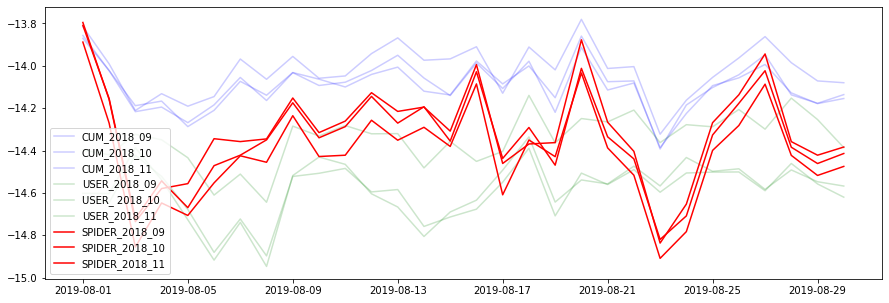

In [ ]:
dates = pd.date_range(start=dt.datetime(2019,8,1), end=dt.datetime(2019,8,30), freq="D")
plt.figure(figsize=(15,5))
plt.plot(dates, KLV_DIV_2019_08[0, 0,::], alpha=0.2, color="b", label="CUM_2018_09")
plt.plot(dates, KLV_DIV_2019_08[0, 1,::], alpha=0.2, color="b", label="CUM_2018_10")
plt.plot(dates, KLV_DIV_2019_08[0, 2,::], alpha=0.2, color="b", label="CUM_2018_11")
plt.plot(dates, KLV_DIV_2019_08[1, 0,::], alpha=0.2, color="g", label="USER_2018_09")
plt.plot(dates, KLV_DIV_2019_08[1, 1,::], alpha=0.2, color="g", label="USER_ 2018_10")
plt.plot(dates, KLV_DIV_2019_08[1, 2,::], alpha=0.2, color="g", label="USER_2018_11")
plt.plot(dates, KLV_DIV_2019_08[2, 0,::], color="r", label="SPIDER_2018_09")
plt.plot(dates, KLV_DIV_2019_08[2, 1,::], color="r", label="SPIDER_2018_10")
plt.plot(dates, KLV_DIV_2019_08[2, 2,::], color="r", label="SPIDER_2018_11")

plt.legend()
plt.show()

dates = pd.date_range(start=dt.datetime(2019,8,1), end=dt.datetime(2019,8,30), freq="D")
plt.figure(figsize=(15,5))
plt.plot(dates, MI_2019_08[0, 0,::], alpha=0.2, color="b", label="CUM_2018_09")
plt.plot(dates, MI_2019_08[0, 1,::], alpha=0.2, color="b", label="CUM_2018_10")
plt.plot(dates, MI_2019_08[0, 2,::], alpha=0.2, color="b", label="CUM_2018_11")
plt.plot(dates, MI_2019_08[1, 0,::], alpha=0.2, color="g", label="USER_2018_09")
plt.plot(dates, MI_2019_08[1, 1,::], alpha=0.2, color="g", label="USER_ 2018_10")
plt.plot(dates, MI_2019_08[1, 2,::], alpha=0.2, color="g", label="USER_2018_11")
plt.plot(dates, MI_2019_08[2, 0,::], color="r", label="SPIDER_2018_09")
plt.plot(dates, MI_2019_08[2, 1,::], color="r", label="SPIDER_2018_10")
plt.plot(dates, MI_2019_08[2, 2,::], color="r", label="SPIDER_2018_11")

plt.legend()
plt.show()


dates = pd.date_range(start=dt.datetime(2019,8,1), end=dt.datetime(2019,8,30), freq="D")
plt.figure(figsize=(15,5))
plt.plot(dates, CENTROPY_2019_08[0, 0,::], alpha=0.2, color="b", label="CUM_2018_09")
plt.plot(dates, CENTROPY_2019_08[0, 1,::], alpha=0.2, color="b", label="CUM_2018_10")
plt.plot(dates, CENTROPY_2019_08[0, 2,::], alpha=0.2, color="b", label="CUM_2018_11")
plt.plot(dates, CENTROPY_2019_08[1, 0,::], alpha=0.2, color="g", label="USER_2018_09")
plt.plot(dates, CENTROPY_2019_08[1, 1,::], alpha=0.2, color="g", label="USER_ 2018_10")
plt.plot(dates, CENTROPY_2019_08[1, 2,::], alpha=0.2, color="g", label="USER_2018_11")
plt.plot(dates, CENTROPY_2019_08[2, 0,::], color="r", label="SPIDER_2018_09")
plt.plot(dates, CENTROPY_2019_08[2, 1,::], color="r", label="SPIDER_2018_10")
plt.plot(dates, CENTROPY_2019_08[2, 2,::], color="r", label="SPIDER_2018_11")

plt.legend()
plt.show()



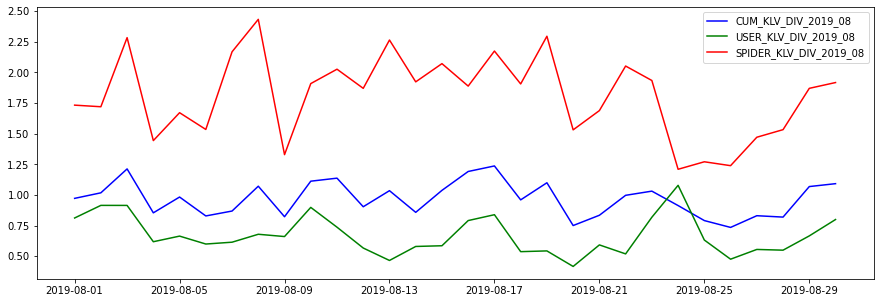

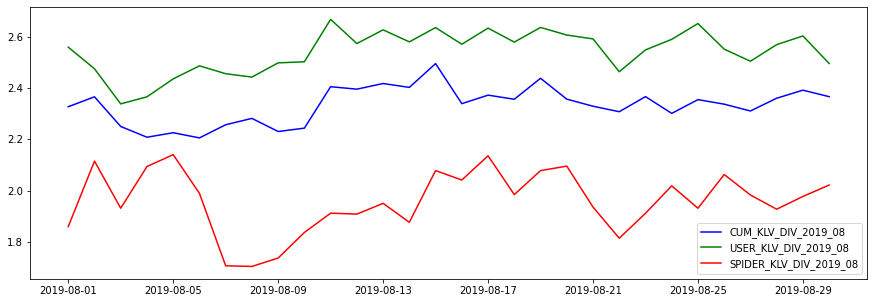

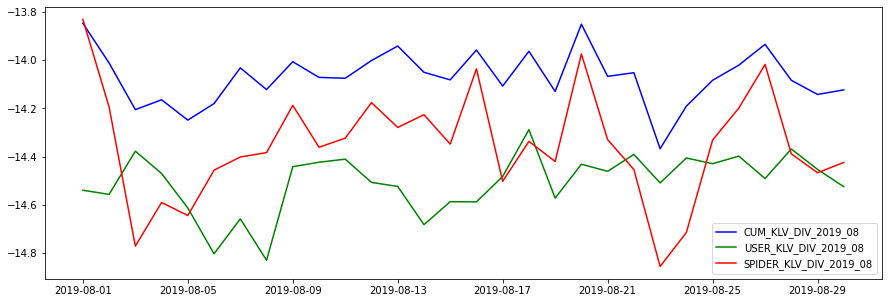

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(dates, np.mean(KLV_DIV_2019_08[0,::,::], axis=0), color="b", label="CUM_KLV_DIV_2019_08")
plt.plot(dates, np.mean(KLV_DIV_2019_08[1,::,::], axis=0), color="g", label="USER_KLV_DIV_2019_08")
plt.plot(dates, np.mean(KLV_DIV_2019_08[2,::,::], axis=0), color="r", label="SPIDER_KLV_DIV_2019_08")

plt.legend()
plt.show()

plt.figure(figsize=(15,5))
plt.plot(dates, np.mean(MI_2019_08[0,::,::], axis=0), color="b", label="CUM_KLV_DIV_2019_08")
plt.plot(dates, np.mean(MI_2019_08[1,::,::], axis=0), color="g", label="USER_KLV_DIV_2019_08")
plt.plot(dates, np.mean(MI_2019_08[2,::,::], axis=0), color="r", label="SPIDER_KLV_DIV_2019_08")

plt.legend()
plt.show()


plt.figure(figsize=(15,5))
plt.plot(dates, np.mean(CENTROPY_2019_08[0,::,::], axis=0), color="b", label="CUM_KLV_DIV_2019_08")
plt.plot(dates, np.mean(CENTROPY_2019_08[1,::,::], axis=0), color="g", label="USER_KLV_DIV_2019_08")
plt.plot(dates, np.mean(CENTROPY_2019_08[2,::,::], axis=0), color="r", label="SPIDER_KLV_DIV_2019_08")

plt.legend()
plt.show()



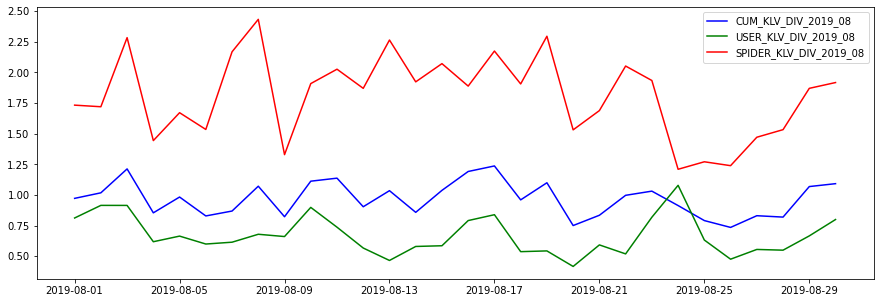

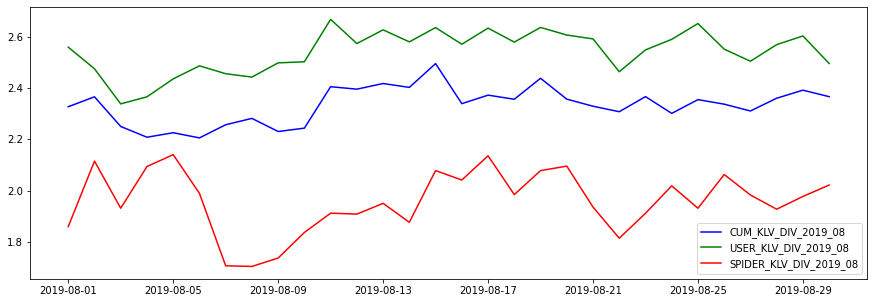

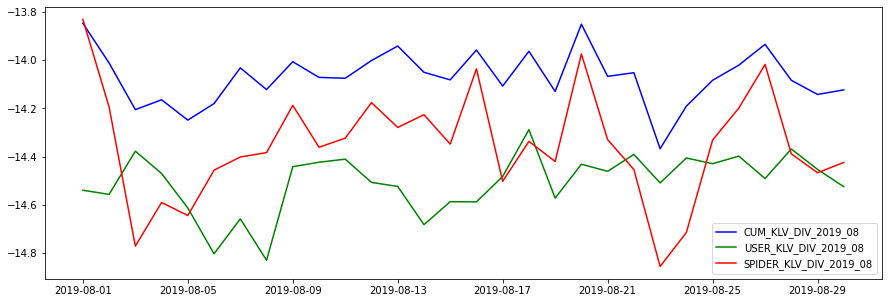

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(dates, np.mean(KLV_DIV_2019_08[0,::,::], axis=0), color="b", label="CUM_KLV_DIV_2019_08")
plt.plot(dates, np.mean(KLV_DIV_2019_08[1,::,::], axis=0), color="g", label="USER_KLV_DIV_2019_08")
plt.plot(dates, np.mean(KLV_DIV_2019_08[2,::,::], axis=0), color="r", label="SPIDER_KLV_DIV_2019_08")

plt.legend()
plt.show()

plt.figure(figsize=(15,5))
plt.plot(dates, np.mean(MI_2019_08[0,::,::], axis=0), color="b", label="CUM_KLV_DIV_2019_08")
plt.plot(dates, np.mean(MI_2019_08[1,::,::], axis=0), color="g", label="USER_KLV_DIV_2019_08")
plt.plot(dates, np.mean(MI_2019_08[2,::,::], axis=0), color="r", label="SPIDER_KLV_DIV_2019_08")

plt.legend()
plt.show()


plt.figure(figsize=(15,5))
plt.plot(dates, np.mean(CENTROPY_2019_08[0,::,::], axis=0), color="b", label="CUM_KLV_DIV_2019_08")
plt.plot(dates, np.mean(CENTROPY_2019_08[1,::,::], axis=0), color="g", label="USER_KLV_DIV_2019_08")
plt.plot(dates, np.mean(CENTROPY_2019_08[2,::,::], axis=0), color="r", label="SPIDER_KLV_DIV_2019_08")

plt.legend()
plt.show()



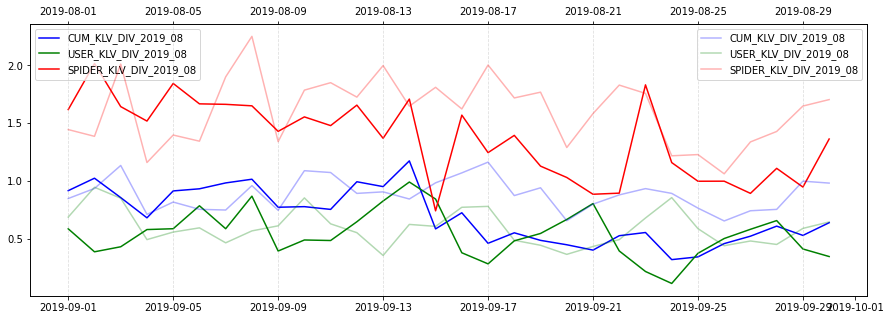

In [ ]:
dates_2019_08 = pd.date_range(start=dt.datetime(2019,8,1), end=dt.datetime(2019,8,30), freq="D")
dates_2019_09 = pd.date_range(start=dt.datetime(2019,9,1), end=dt.datetime(2019,9,30), freq="D")

fig, ax1 = plt.subplots(figsize=(15,5))


ax1.plot(dates_2019_09, np.mean(KLV_DIV_2019_09[0,::,::], axis=0), color="b", label="CUM_KLV_DIV_2019_08")
ax1.plot(dates_2019_09, np.mean(KLV_DIV_2019_09[1,::,::], axis=0), color="g", label="USER_KLV_DIV_2019_08")
ax1.plot(dates_2019_09, np.mean(KLV_DIV_2019_09[2,::,::], axis=0), color="r", label="SPIDER_KLV_DIV_2019_08")
ax1.legend(loc=2)

ax2 = ax1.twiny()
ax2.plot(dates_2019_08, np.mean(KLV_DIV_2019_08[0,::,::], axis=0), alpha=0.3, color="b", label="CUM_KLV_DIV_2019_08")
ax2.plot(dates_2019_08, np.mean(KLV_DIV_2019_08[1,::,::], axis=0), alpha=0.3, color="g", label="USER_KLV_DIV_2019_08")
ax2.plot(dates_2019_08, np.mean(KLV_DIV_2019_08[2,::,::], axis=0), alpha=0.3, color="r", label="SPIDER_KLV_DIV_2019_08")
ax2.legend(loc=1)

plt.grid(linestyle="--", alpha=0.4)
plt.show()


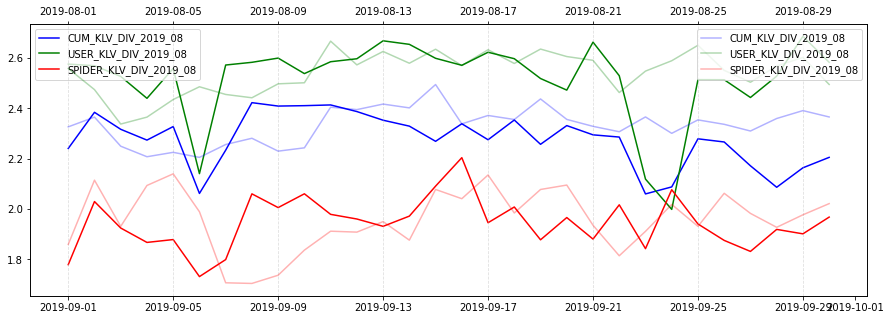

In [ ]:
dates_2019_08 = pd.date_range(start=dt.datetime(2019,8,1), end=dt.datetime(2019,8,30), freq="D")
dates_2019_09 = pd.date_range(start=dt.datetime(2019,9,1), end=dt.datetime(2019,9,30), freq="D")

fig, ax1 = plt.subplots(figsize=(15,5))


ax1.plot(dates_2019_09, np.mean(MI_2019_09[0,::,::], axis=0), color="b", label="CUM_KLV_DIV_2019_08")
ax1.plot(dates_2019_09, np.mean(MI_2019_09[1,::,::], axis=0), color="g", label="USER_KLV_DIV_2019_08")
ax1.plot(dates_2019_09, np.mean(MI_2019_09[2,::,::], axis=0), color="r", label="SPIDER_KLV_DIV_2019_08")
ax1.legend(loc=2)

ax2 = ax1.twiny()
ax2.plot(dates_2019_08, np.mean(MI_2019_08[0,::,::], axis=0), alpha=0.3, color="b", label="CUM_KLV_DIV_2019_08")
ax2.plot(dates_2019_08, np.mean(MI_2019_08[1,::,::], axis=0), alpha=0.3, color="g", label="USER_KLV_DIV_2019_08")
ax2.plot(dates_2019_08, np.mean(MI_2019_08[2,::,::], axis=0), alpha=0.3, color="r", label="SPIDER_KLV_DIV_2019_08")
ax2.legend(loc=1)

plt.grid(linestyle="--", alpha=0.4)
plt.show()


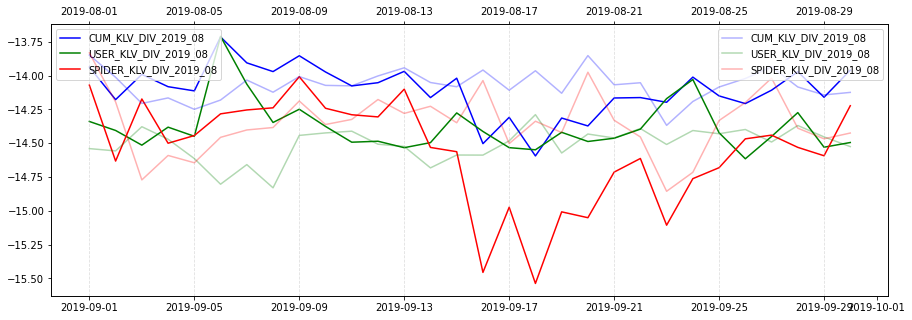

In [ ]:
dates_2019_08 = pd.date_range(start=dt.datetime(2019,8,1), end=dt.datetime(2019,8,30), freq="D")
dates_2019_09 = pd.date_range(start=dt.datetime(2019,9,1), end=dt.datetime(2019,9,30), freq="D")

fig, ax1 = plt.subplots(figsize=(15,5))


ax1.plot(dates_2019_09, np.mean(CENTROPY_2019_09[0,::,::], axis=0), color="b", label="CUM_KLV_DIV_2019_08")
ax1.plot(dates_2019_09, np.mean(CENTROPY_2019_09[1,::,::], axis=0), color="g", label="USER_KLV_DIV_2019_08")
ax1.plot(dates_2019_09, np.mean(CENTROPY_2019_09[2,::,::], axis=0), color="r", label="SPIDER_KLV_DIV_2019_08")
ax1.legend(loc=2)

ax2 = ax1.twiny()
ax2.plot(dates_2019_08, np.mean(CENTROPY_2019_08[0,::,::], axis=0), alpha=0.3, color="b", label="CUM_KLV_DIV_2019_08")
ax2.plot(dates_2019_08, np.mean(CENTROPY_2019_08[1,::,::], axis=0), alpha=0.3, color="g", label="USER_KLV_DIV_2019_08")
ax2.plot(dates_2019_08, np.mean(CENTROPY_2019_08[2,::,::], axis=0), alpha=0.3, color="r", label="SPIDER_KLV_DIV_2019_08")
ax2.legend(loc=1)

plt.grid(linestyle="--", alpha=0.4)
plt.show()
